# 1.Update all data

In [1]:
# %load ../src/data/get_data.py
import os
import subprocess
import git

import pandas as pd
import numpy as np

from datetime import datetime

import requests
import json

def get_johns_hopkins():
    git.Git('C:/Users/96931/anac_home/Applied data science/ads_covid-19/data/raw/COVID-19').pull("https://github.com/CSSEGISandData/COVID-19.git")


def get_current_data_germany():
    
    # 16 states
    #data=requests.get('https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/Coronaf%C3%A4lle_in_den_Bundesl%C3%A4ndern/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json')
    
    # 400 regions
    data=requests.get('https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_Landkreisdaten/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json')
    
    json_object=json.loads(data.content)
    full_list=[]
    for pos, each_dict in enumerate(json_object['features'][:]):
        full_list.append(each_dict['attributes'])

    pd_full_list=pd.DataFrame(full_list)
    pd_full_list.to_csv('../data/raw/NPGEO/GER_state_data.csv',sep=';')
    print('Number of regions rows:'+str(pd_full_list.shape[0]))

if __name__=='__main__':
    get_johns_hopkins()
    get_current_data_germany()
    


Number of regions rows:412


# 2.Process Pipeline

In [2]:
# %load ../src/data/process_JH_data.py
import pandas as pd
import numpy as np

from datetime import datetime


def store_relational_JH_data():
    data_path='../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    pd_raw=pd.read_csv(data_path)
    
    pd_data_base=pd_raw.rename(columns={'Country/Region':'country', 'Province/State' : 'state'})
    pd_data_base['state']=pd_data_base['state'].fillna('no')
    pd_data_base=pd_data_base.drop(['Lat','Long'], axis=1)
    
    pd_relational_model=pd_data_base.set_index(['state', 'country']).T.stack(level=[0,1]).reset_index().rename(columns={'level_0':'date', 0:'confirmed'})
    
    pd_relational_model.dtypes
    pd_relational_model['date']=pd_relational_model.date.astype('datetime64[ns]')
                                               
    pd_relational_model.to_csv('../data/processed/COVID_relational_confirmed.csv', sep=';',index=False)

    print('Number of rows stored:'+str(pd_relational_model.shape[0]))

if __name__=='__main__':
                                               
    store_relational_JH_data()


Number of rows stored:61180


# 3.Filter and Doubling Rate Calculation

In [3]:
# %load ../src/features/build_features.py
import numpy as np
import pandas as pd
from sklearn import linear_model
from scipy import signal


reg = linear_model.LinearRegression(fit_intercept=True)

def get_doubling_time_via_regression(in_array):

    y=np.array(in_array)
    X=np.arange(-1,2).reshape(-1,1)

    assert len(in_array)==3
    
    reg.fit(X,y)
    intercept=reg.intercept_
    slope=reg.coef_
    
    return intercept/slope



def savgol_filter(df_input,column='confirmed', window=5):

    degree=1

    df_result=df_input

    filter_in=df_input[column].fillna(0)

    result=signal.savgol_filter(np.array(filter_in), window, degree)

    df_result[str(column+'_filtered')]=result
    
    return df_result


def rolling_reg(df_input, col='confirmed'):

    days_back=3
    result=df_input[col].rolling(window=days_back, min_periods=days_back).apply(get_doubling_time_via_regression, raw=False)
    return result


def calc_filtered_data(df_input,filter_on='confirmed'):

    must_contain=set(['state','country',filter_on])
    assert must_contain.issubset(set(df_input.columns))
    
    df_output=df_input.copy()

    pd_filtered_result=df_input[['state','country',filter_on]].groupby(['state','country']).apply(savgol_filter)
    df_output=pd.merge(df_output,pd_filtered_result[[str(filter_on+'_filtered')]],left_index=True,right_index=True,how='left')

    return df_output.copy()


def calc_doubling_rate(df_input,filter_on='confirmed'):

    must_contain=set(['state','country',filter_on])
    assert must_contain.issubset(set(df_input.columns))

    pd_DR_result=df_input.groupby(['state','country']).apply(rolling_reg,filter_on).reset_index()
    pd_DR_result=pd_DR_result.rename(columns={filter_on:filter_on+'_DR','level_2':'index'})

    df_output=pd.merge(df_input,pd_DR_result[['index',str(filter_on+'_DR')]],left_index=True,right_on=['index'],how='left')
    df_output=df_output.drop(columns=['index'])
    return df_output



if __name__=='__main__':
    test_data_reg=np.array([2,4,6])                 
    result=get_doubling_time_via_regression(test_data_reg)
    print('The test slope is:'+str(result))

    pd_JH_data=pd.read_csv('../data/processed/COVID_relational_confirmed.csv', sep=';',parse_dates=[0])
    pd_JH_data=pd_JH_data.sort_values('date',ascending=True).copy()

    pd_result_larg=calc_filtered_data(pd_JH_data)
    pd_result_larg=calc_doubling_rate(pd_result_larg)
    pd_result_larg=calc_doubling_rate(pd_result_larg,'confirmed_filtered')
    
    mask=pd_result_larg['confirmed']>50
    pd_result_larg['confirmed_filtered_DR']=pd_result_larg['confirmed_filtered_DR'].where(mask, other=np.NaN)
    pd_result_larg.to_csv('../data/processed/COVID_final_set.csv', sep=';',index=False)
    print(pd_result_larg[pd_result_larg['country']=='US'].tail())


The test slope is:[2.]
            date state country  confirmed  confirmed_filtered  confirmed_DR  \
58185 2020-09-03    no      US  6150016.0           6156570.8    160.482444   
58186 2020-09-04    no      US  6200518.0           6197075.8    141.473918   
58187 2020-09-05    no      US  6244970.0           6234498.2    130.557982   
58188 2020-09-06    no      US  6276365.0           6272204.1    164.558062   
58189 2020-09-07    no      US  6300622.0           6309910.0    225.472064   

       confirmed_filtered_DR  
58185             146.112758  
58186             147.653206  
58187             159.021044  
58188             165.971883  
58189             166.345429  


# 4.Build SIR Simulation Model

In [4]:
# %load ../src/models/SIR_spread_model.py
import numpy as np
import pandas as pd
from scipy import optimize
from scipy import integrate

def fit_odeint(x, beta, gamma):
    return integrate.odeint(SIR_model_t, (S0,I0,R0),  t, args=(beta,gamma))[:,1]

def SIR_model_t(SIR,t,beta,gamma):
    '''
        S: susceptible population
        I: infected population
        R: Recovered population
        
        dS+dI+dR=0
        S+I+R=N
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

pd_raw=pd.read_csv('../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

#Sum up the total confirmed cases in each country
total_confirmed_in_country=pd.DataFrame()
for each in pd_raw['Country/Region'].copy().drop_duplicates():
    for col in range(4,pd_raw.shape[1]-1):
        total_confirmed_in_country.loc[col-4,each]=pd_raw[pd_raw['Country/Region']==each].iloc[:,col].sum()

#Store the simulation result
SIR_spread_model={}
SIR_idx={}

beta=0.7
gamma=0.1

#Calculate simulation
for each in pd_raw['Country/Region'].drop_duplicates():
    
    n = 0
    for n in range(35,200):
        if total_confirmed_in_country[each].iloc[n]>5:
            SIR_idx[each]=n
            break
            
    ydata=np.array(total_confirmed_in_country[each].iloc[SIR_idx[each]:])
    t=np.arange(len(ydata))
    
    I0=ydata[0]
    R0=0
    
    popt=[beta,gamma]
    
    #pcov_cand={}
    #popt_cand={}
    
    for ord in range(3,11):
        N0=pow(10,ord)
        S0=N0-I0
        
        try:
            popt, pcov= optimize.curve_fit(fit_odeint, t, ydata)
        except:
            continue #error might encounter when N0 is too small
        else:
            if (np.sqrt(np.diag(pcov))[0]<0.01) and (np.sqrt(np.diag(pcov))[1]<0.01):
                break
                #print(np.sqrt(np.diag(pcov))[0]+np.sqrt(np.diag(pcov))[1])
                #popt_cand[np.sqrt(np.diag(pcov))[0]+np.sqrt(np.diag(pcov))[1]]=popt
                
    SIR_spread_model[each]=fit_odeint(t,*popt)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars
D:\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
D:\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in double_scalars
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


# 5.Dynamic beta in SIR (infection rate)

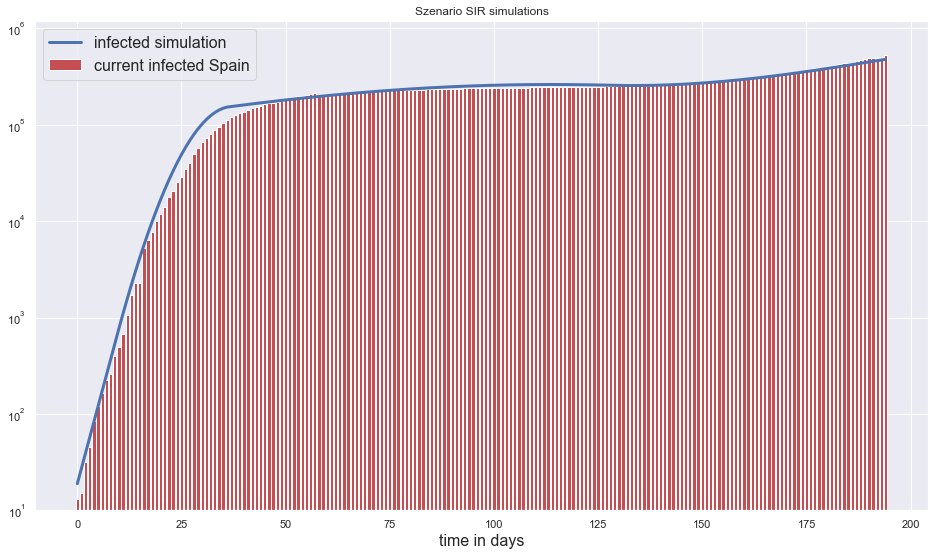

In [5]:
# %load ../src/models/dynamic_SIR_model.py
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
mpl.rcParams['figure.figsize']=(16,9)

pd_raw=pd.read_csv('../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
time_idx=pd_raw.columns[4:]
df_Spain=pd.DataFrame({'date':time_idx})
df_Spain['number']=np.array(pd_raw[pd_raw['Country/Region']=='Spain'].iloc[:,4:].sum(axis=0))

def SIR_model(SIR,beta,gamma):
    '''
        S: susceptible population
        I: infected population
        R: Recovered population
        
        dS+dI+dR=0
        S+I+R=N
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


t_initial=10
t_intro_measures=28
t_hold=90
t_relax=67

beta_max=0.55
beta_min=0.115
gamma=0.1

ydata = np.array(df_Spain.number[35:])
t=np.arange(len(ydata))

N0=16000000
I0=ydata[0]
S0=N0-I0
R0=0

pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                        np.linspace(beta_max,beta_min,t_intro_measures),
                        np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_min+0.05,t_relax),
                       ))


SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={
    'susceptible':S0,
    'infected':I0,
    'recovered':R0
})

for each_beta in pd_beta:
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
    SIR=SIR+new_delta_vec
    propagation_rates=propagation_rates.append({
    'susceptible':SIR[0],
    'infected':SIR[1],
    'recovered':SIR[2]},
    ignore_index=True
    )

fig, axl = plt.subplots(1,1)

axl.plot(propagation_rates.index,propagation_rates.infected,label='infected simulation',linewidth=3)

axl.bar(np.arange(len(ydata)),ydata,width=0.8,label='current infected Spain',color='r')
axl.set_ylim(10,2.5*max(propagation_rates.infected))
axl.set_yscale('log')
axl.set_title('Szenario SIR simulations')
axl.set_xlabel('time in days', size=16)
axl.legend(loc='best',prop={'size':16})


# 6.Visual Board

In [6]:
# %load ../src/visualization/visualize.py
import pandas as pd
import numpy as np

import dash
dash.__version__
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

import plotly.graph_objects as go

import os
print(os.getcwd())

df_input_large=pd.read_csv('../data/processed/COVID_final_set.csv', sep=';')


fig=go.Figure()

app=dash.Dash()
app.layout=html.Div([

    dcc.Markdown('''
    ## Applied Data Science on COVID-19 data

    This project is aim to show the data of confirmed cases and the doubling rates 
    in different country. This project was worked by applying a cross industry standard process,
    it covers the full walkthrough of: automated data gathering, data transformations,
    filtering and machine learning to approximating the doubling time, and (static) deployment of responsive dashboard.

    '''),
    
     dcc.Markdown('''
    ## Multi_Select Country for visualization
                  '''),
    
    dcc.Dropdown(
        id='country_drop_down',
        options=[{'label':each, 'value':each} for each in df_input_large['country'].unique()],
        value=['US','Ukraine','Georgia'], #pre-selected
        multi=True
    ),

    dcc.Markdown('''
    ## Select Timeline of confirmed COVID-19 cases on different topics
                 '''),
    
    dcc.Dropdown(
        id='doubling_time',
        options=[
            {'label':'Timeline Confirmed','value':'confirmed'},
            {'label':'Timeline Confirmed Filtered','value':'confirmed_filtered'},
            {'label':'Timeline Doubling Rate','value':'confirmed_DR'},
            {'label':'Timeline Doubling Rate Filtered','value':'confirmed_filtered_DR'},
            {'label':'SIR Virus Spread Model','value':'SIR_spread_model'}
        ],
        value='confirmed', #pre-selected
        multi=False
    ),

    dcc.Graph(figure=fig, id='main_window_slope')
    ])

@app.callback(
    Output('main_window_slope','figure'),
    [Input('country_drop_down','value'),
     Input('doubling_time','value')])

def update_figure(country_list,show_doubling):

    if'DR'in show_doubling:
        my_yaxis={
            'type':'log',
            'title':'Approximated doubling rate over 3 days, log-scale'
            }
    else:
        my_yaxis={
            'type':'log',
            'title':'Confirmed infected people (source johns hopkins csse, log-scale)'
            }
        
    if 'SIR_spread_model' in show_doubling:
        my_yaxis={
            'type':'log',
            'title':'True confirmed cases and corresponding simulation curve, log-scale'
            }

    traces=[]
    
    for each in country_list:

        df_plot=df_input_large[df_input_large['country']==each]

        if show_doubling=='doubling_rate_filtered':
            df_plot=df_plot[['state','country','confirmed','confirmed_filtered','confirmed_DR','confirmed_filtered_DR','date']].groupby(['country','date']).agg(np.mean).reset_index()
        else:
            df_plot=df_plot[['state','country','confirmed','confirmed_filtered','confirmed_DR','confirmed_filtered_DR','date']].groupby(['country','date']).agg(np.sum).reset_index()

        
        if show_doubling=='SIR_spread_model':
            
            df_plot[show_doubling]=np.append(np.zeros(SIR_idx[each]+1),total_confirmed_in_country[each][SIR_idx[each]:])
            df_plot[show_doubling][0:SIR_idx[each]+1]=np.nan

            traces.append(dict(
                        x=df_plot.date[SIR_idx[each]:],
                        y=SIR_spread_model[each],
                        mode='lines',
                        opacity=1,
                        #line_width=2,
                        #marker_size=2,
                        name=each+'_simulation')

                      )

        traces.append(dict(
            x=df_plot.date,
            y=df_plot[show_doubling],
            mode='markers+lines',
            opacity=0.6,
            #line_width=2,
            #marker_size=2,
            name=each)

            )



    return{

        'data':traces,
        'layout':dict(
            width=1280,
            height=720,
            xaxis={
                'title':'Timeline',
                'tickangle':-45,
                'nticks':20,
                'tickfont':dict(size=14,color='#7f7f7f')},
            yaxis=my_yaxis
            )
        
        }

if __name__=='__main__':
    app.run_server(debug=True,use_reloader=False)


C:\Users\96931\anac_home\Applied data science\ads_covid-19\notebooks
Dash is running on http://127.0.0.1:8050/

 in production, use a production WSGI server like gunicorn instead.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

